# **Entrega 3 - Proyecto Integrador**
**Grupo 8 - 5K9 (Bürky, Lucía - Citro, Camila)**

En este Notebook se desarrolla la tercera entrega del Proyecto Integrador de Ciencia de Datos, utilizando como entrada las hipótesis y los resultados del análisis exploratorio realizado en la entrega anterior.



---

## ***Introducción***
En esta entrega, con el uso de un modelo de *Machine Learning*, vamos a utilizar distintos modelos para:
1. Predecir el género de canciones.
2. Intentar agrupar y/o clasificar las canciones en base a sus características


#### *1. Aprendizaje supervisado: Clasificación de Género*
**Objetivo predictivo:** predecir el género musical primario (genre_rosamerica) de una canción basándose en sus propiedades acústicas y su contexto temporal.

Esto se hará a partir de sus características, tales como:

| Característica | Descripcion                                               |
| -------------- | --------------------------------------------------------- |
| `happy`        | Porcentaje de "felicidad" de una canción                  |
| `sad`          | Porcentaje de "tristeza" de una canción                   |  
| `danceable`    | Porcentaje de "bailable" de una canción                   |  
| `party`        | Porcentaje de "fiestera" de una canción                   |  
| `tonal`        | Porcentaje de "estable" de una canción, en referencia a un tono central                  |  
| `bright`       | Porcentaje de "brillante" de una canción, usando como referencia los "colores" de las melodías utilizadas en la misma                  |  
| `relaxed`      | Porcentaje de "relajada" de una canción                   |
| `acoustic`     | Porcentaje de "acústica" de una canción                   |
| `instrumental` | Porcentaje de "instrumental" de una canción, referido a qué tanto predominan los instrumentos por sobre las voces                    |

Los géneros posibles de las canciones son:
1.   ***Pop***
2.   ***Rock***
3.   ***Dance***
4.   ***Rhythmic***
5.   ***Hip-Hop***
6.   ***Jazz***
7.   ***Classic***



#### *2. Aprendizaje no supervisado: Agrupación de canciones con características similares*
**Objetivo predictivo:** identificar grupos naturales de canciones dentro del conjunto de datos, utilizando las características mencionadas anteriormente (`happy`, `sad`, `danceable`, `acoustic`, etc.), esperando poder dividir según los géneros, o conseguir alguna división que sea de interés.

---
## ***Objetivo general de la entrega***
El objetivo general de esta entrega es conseguir un punto de partida para construir un modelo de recomendación de canciones basado en las características de las mismas, y del evento o estado de ánimo específico del usuario.



---


## ***Preparación inicial***
En esta sección, vamos a preparar los datos a utilizar en el modelo a realizar.

Vamos a importar el archivo con el que vamos a trabajar, seleccionar la variable objetivo y las features. Además, vamos a separar en conjunto de entrenamiento y test.

### 1. Importación del archivo
Acá vamos a importar el archivo *songs_final_entrante*, que es la salida de la entrega anterior.

In [ ]:
import pandas as pd
!gdown 10FoWK1Egk0BOLuIX5SnVrUnRnR1IH1Ul
df = pd.read_csv("1000_canciones.csv")

df.head()

Downloading...
From: https://drive.google.com/uc?id=10FoWK1Egk0BOLuIX5SnVrUnRnR1IH1Ul
To: /content/1000_canciones.csv
100% 277k/277k [00:00<00:00, 94.5MB/s]


,sad,date,happy,party,title,tonal,bright,length,relaxed,acoustic,danceable,track_mbid,artist_name,instrumental,genre_dortmund,genre_rosamerica,genre_tzanetakis,decada,longitud_titulo
0,0.460398,2022,0.113453,0.164896,Moscow Mule,0.022388,0.583826,4.100000,0.933004,0.194239,0.989577,27117064-7212-4d61-9caf-4260c6a97d78,Bad Bunny,0.310921,Electronic,Pop,Rock,2020,11
1,0.610621,2022,0.014217,0.611525,Efecto,0.136099,0.832278,3.551021,0.899730,0.211885,0.456109,782ee794-afb3-4adb-a1d7-c6fdc1d945de,Bad Bunny,0.362623,Electronic,Rhythmic,Jazz,2020,6
2,0.648042,2022,0.123715,0.000082,Neverita,0.960025,0.989367,2.885322,0.808817,0.077899,0.354812,0b500297-1d57-4934-b620-9f8d2612d19e,Bad Bunny,0.000772,Electronic,Rhythmic,Jazz,2020,8
3,0.331451,2022,0.346221,0.096425,Después de la playa,0.920050,0.928968,3.840000,0.612284,0.179519,0.938280,8aa7b603-fcd9-40c9-a3a5-0d000fc7c3b7,Bad Bunny,0.592532,Electronic,Dance,Jazz,2020,19
4,0.760215,2022,0.155164,0.167294,Yo no soy celoso,0.620191,0.996080,3.845071,0.603947,0.872718,0.565776,4f2c1f6d-25fd-4336-8825-07b4f22a6b19,Bad Bunny,0.319427,Electronic,Rhythmic,Jazz,2020,16


In [ ]:
df.shape

(1097, 19)

Además de lo anterior, comprobaremos qué columnas poseen valores nulos que podrían traernos problemas a futuro.

In [ ]:
cols_with_nulls = df.columns[df.isna().any()]

print(f"Columnas con valores nulos: {cols_with_nulls}")

Columnas con valores nulos: Index([], dtype='object')


Antes de comenzar, queremos comprobar la proporción de cada género que poseen nuestros datos.

In [ ]:
frecuencias = df['genre_rosamerica'].value_counts(normalize=True) * 100
frecuencias_df = frecuencias.reset_index()
frecuencias_df.columns = ['genre_rosamerica', 'porcentaje']
frecuencias_df

,genre_rosamerica,porcentaje
0,Pop,29.990884
1,Rhythmic,28.076572
2,Rock,15.223336
3,Hip-Hop,11.030082
4,Dance,8.386509
5,Jazz,4.010939
6,Classic,3.281677


Observamos que hay un género "Speech" que es muy poco común. Menos del 1% de las canciones poseen este género. Por lo tanto, procedemos a eliminarlo ya que lo consideramos poco representativo y así no tendremos problemas al predecir.

In [ ]:
poco_frecuentes = frecuencias[frecuencias < 1].index
df = df[~df['genre_rosamerica'].isin(poco_frecuentes)]

In [ ]:
# Mostrar cuántos duplicados hay antes
duplicados = df.duplicated(subset=['track_mbid'])
print(f"Cantidad de canciones duplicadas: {duplicados.sum()}")

# Eliminar duplicados conservando la primera aparición
df_sin_duplicados = df.drop_duplicates(subset=['track_mbid'], keep='first')
df=df_sin_duplicados
# Verificar resultado
print(f"Cantidad de filas antes: {len(df)}")
print(f"Cantidad de filas después de eliminar duplicados: {len(df_sin_duplicados)}")

Cantidad de canciones duplicadas: 0
Cantidad de filas antes: 1097
Cantidad de filas después de eliminar duplicados: 1097


In [ ]:
df_a_eliminar = df

df_a_eliminar = df_a_eliminar[~df_a_eliminar['artist_name'].isna()]

df = df_a_eliminar

In [ ]:
df.shape

(1097, 19)

### 2. Selección de features y variable objetivo
En esta subsección, vamos a seleccionar la variable objetivo (`genre_rosamerica`) y las features con las que vamos a predecir el objetivo.

Por el momento, vamos a seleccionar como features a todas las demás columnas que no sean `genre`.


In [ ]:
# Variable objetivo
y = df["genre_rosamerica"]

# Features (por ahora, solamente sacamos la objetivo)
X = df.drop(columns=["genre_rosamerica"])

### 3. División en conjunto de entrenamiento y test
Aquí, vamos a separar el .csv de los datos en dos conjuntos: entrenamiento (80%) y test (20%). Además, vamos a verificar el tamaño de cada uno.
- Conjunto de entrenamiento: utilizado para entrenar el pipeline.
- Conjunto de prueba: utilizado para la evaluación final.

Como estrategia, utilizaremos `stratify=y` al momento de la división para asegurar que la proporción de los 7 géneros sea la misma tanto en el conjunto de entrenamiento como en el de pruebas, así evitaremos posibles sesgos.

In [ ]:
from sklearn.model_selection import train_test_split

# Separamos los conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verificamos tamaño de cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de test: {X_test.shape[0]} muestras")

Conjunto de entrenamiento: 36460 muestras
Conjunto de test: 9115 muestras




---


## ***Preprocesamiento de los datos***
En esta sección, vamos a construir un pipeline que va a servir para dejar listos los datos para la predicción.

### 1. Limpieza de columnas irrelevantes
Acá vamos a eliminar aquellas columnas que no son relevantes para la predicción, que son:
* `title`
* `track_mbid`
* `artist_name`
* `date`
* `length`
* `longitud_titulo`

Además, eliminaremos dos columnas que podrían llegar a generar un target leakage ya que se trata de otros géneros de canciones. Y como nuestro objetivo es predecir el género en base a las características de las canciones, no se utilizarán los otros géneros:
* `genre_tzanetakis`
* `genre_dortmund`


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

### 2. Pipeline numérico
A pesar de haber observado que nuestras variables numéricas todas poseen valores, es decir, no hay filas con valores nulos. Para prevenir cualquier inconveniente, en nuestro pipeline numérico agregaremos la imputación. Además, a pesar de saber que nuestras variables numéricas poseen valores que se encuentran entre 0 y 1, por las dudas realizaremos el escalado.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

### 2. Pipeline categórico
Una de las variables que no fue eliminada fue la década. Utilizaremos a esta variable como categórica ya que quizás pueda traernos información útil para predicciones.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

### 3. Composición con el ColumnTransformer

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_selector

column_transform = ColumnTransformer([
    ("num", numeric_pipeline, make_column_selector(dtype_include=["int64", "float64"])),
    ("cat", categorical_pipeline, make_column_selector(dtype_include=["object", "category"]))
])

### 4. Ingenieria de caracteristicas


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class MusicIndexCreator(BaseEstimator, TransformerMixin):
    def __init__(self, drop_original=True):
        self.drop_original = drop_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
             column_names = ['sad', 'happy', 'party', 'tonal', 'bright', 'relaxed',
                             'acoustic', 'danceable', 'instrumental']
             X_ = pd.DataFrame(X, columns=column_names)
        else:
             X_ = X.copy()

        # Índice de Ánimo
        X_["mood_index"] = X_["happy"] - X_["sad"]

        # Índice de Energía
        X_["energy_index"] = X_["party"] - X_["relaxed"]


        # Eliminación de las columnas originales
        if self.drop_original:
            X_ = X_.drop(columns=["sad", "happy", "party", "relaxed"])

        return X_

### 4. Pipeline final
Por último, vamos a correr el pipeline con la función creada anteriormente.

In [ ]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ("drop_columns", DropColumns(columns_to_drop=["date", "title","track_mbid","genre_dortmund", "genre_tzanetakis","artist_name", "longitud_titulo", "length"])),
    ("music_index_creator", MusicIndexCreator()),
     ("column_transform", column_transform)
])

In [ ]:
# Mostramos la salida del preprocesamiento
preprocessor.fit_transform(X_train)

array([[4.75892295e-02, 9.96306538e-01, 5.63506553e-02, ...,
        9.09090909e-01, 3.40617976e-01, 1.89583658e-01],
       [9.97743189e-01, 1.62259620e-02, 9.55333267e-01, ...,
        8.18181818e-01, 2.35624125e-01, 4.45003687e-02],
       [5.54922587e-01, 5.40850048e-01, 5.34458941e-01, ...,
        7.27272727e-01, 5.29449921e-01, 1.99154659e-01],
       ...,
       [4.93628260e-06, 9.88312958e-01, 6.53733070e-01, ...,
        8.18181818e-01, 9.04022154e-01, 8.64753345e-01],
       [6.43319294e-03, 4.12697454e-01, 1.51026574e-02, ...,
        8.18181818e-01, 6.18679009e-01, 7.49314787e-01],
       [5.21772924e-01, 9.38029401e-01, 6.68973470e-01, ...,
        7.27272727e-01, 7.28850188e-01, 2.17362646e-01]])



---


## ***Entrenamiento de modelos: Aprendizaje supervisado***
En esta sección, vamos a entrenar a los modelos sin ningún ajuste.

Pero antes, vamos a declarar la función a utilizar para evaluar los modelos. Esta función se va a llamar cada vez que se realice una predicción.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluar_modelo_prediccion(nombre, y_true, y_pred):
    print(f"\n 👀 MODELO: {nombre}\n")
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))

### ***1. K-Neighbors Classifier (KNN)***

***Funcionamiento del modelo***:
Al intentar predecir el género de una canción, busca las canciones más cercanas en el conjunto de entrenamiento, pero "cercanas" en términos de similitud numérica entre sus características. Es decir, al recibir una nueva cancion para predecirle el género, el modelo:
1. Calcula la distancia entre esa canción y cada una de las canciones del conjunto de entrenamiento.
2. Ordena esas distancias de menor a mayor.
3. Se queda con las K canciones (filas) que resultan más cercanas numéricamente.
4. Mira las etiquetas de género de esas canciones y asigna la clase mayoritaria entre ellas.



Decidimos iniciar con el modelo KNN ya que es sencillo y transparente y creemos que puede ser una buena base.

Este modelo, clasifica una canción nueva asignándole el género de sus K vecinos más cercanos en el espacio de características.

Nosotras partimos con un K=5 como valor inicial, ya que es un valor común que balancea el ruido (K=1) y la suavización excesiva (K alto).



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_k_neighbors = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

pipeline_k_neighbors.fit(X_train, y_train)

y_pred_k_neighbors = pipeline_k_neighbors.predict(X_test)

evaluar_modelo_prediccion("K-Neighbors Classifier", y_test, y_pred_k_neighbors)


 👀 MODELO: K-Neighbors Classifier

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.610     0.724     0.662       493
       Dance      0.482     0.596     0.533       267
     Hip-Hop      0.514     0.588     0.549       277
        Jazz      0.434     0.347     0.386       277
         Pop      0.438     0.420     0.429       559
    Rhythmic      0.599     0.520     0.557       748
        Rock      0.727     0.706     0.717       616

    accuracy                          0.567      3237
   macro avg      0.544     0.557     0.547      3237
weighted avg      0.566     0.567     0.564      3237

Matriz de confusión:
[[357   2   3  50  18  50  13]
 [  1 159  53   0  25  11  18]
 [  2  47 163   1  24  26  14]
 [ 89   1   3  96  30  45  13]
 [ 27  54  45  20 235  97  81]
 [ 93  32  33  45 132 389  24]
 [ 16  35  17   9  73  31 435]]


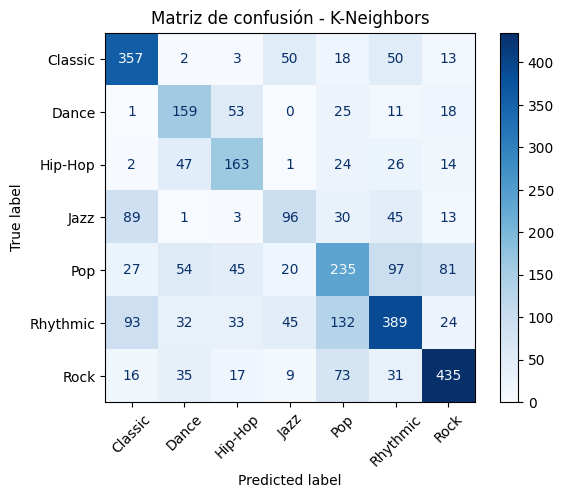

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline_k_neighbors, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - K-Neighbors")
plt.show()

#### Análisis de resultados
Teniendo un k=5, el rendimiento inicial fue moderado, obteniendo un `accuracy` aproximado del 56.7%.

Además, notamos un desempeño bastante desigual entre las clases.

Esto nos indicó que le modelo, inicialmente no está muy bien configurado ya que no está detectando bien las diferencias tonales entre géneros.

#### Ajuste de hiperparámetros
Utilizamos GridSearchCV para la búsqueda de hiperparámetros para ver cómo mejorar nuestro modelo.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_kn = {'classifier__n_neighbors': np.arange(1, 21)}

grid_search_kn = GridSearchCV(
    pipeline_k_neighbors,
    param_grid_kn,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_kn.fit(X_train, y_train)

print(f"Mejor valor de K encontrado: {grid_search_kn.best_params_['classifier__n_neighbors']}")
print(f"Mejor precisión con Cross-Validation: {grid_search_kn.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor valor de K encontrado: 1
Mejor precisión con Cross-Validation: 0.6555


Se identificó que con un `K=1` como el valor óptimo. Luego, aplicamos la modificación en nuestro modelo, para ver si realmente mejora con este ajuste.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_k_neighbors_v2 = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=1))
])

pipeline_k_neighbors_v2.fit(X_train, y_train)

y_pred_k_neighbors_v2 = pipeline_k_neighbors_v2.predict(X_test)

evaluar_modelo_prediccion("K-Neighbors Classifier v2", y_test, y_pred_k_neighbors_v2)


 👀 MODELO: K-Neighbors Classifier v2

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.730     0.724     0.727       493
       Dance      0.708     0.700     0.704       267
     Hip-Hop      0.679     0.747     0.711       277
        Jazz      0.585     0.621     0.602       277
         Pop      0.623     0.594     0.608       559
    Rhythmic      0.691     0.671     0.681       748
        Rock      0.781     0.794     0.787       616

    accuracy                          0.694      3237
   macro avg      0.685     0.693     0.689      3237
weighted avg      0.694     0.694     0.694      3237

Matriz de confusión:
[[357   2   2  59  16  48   9]
 [  0 187  33   1  20  10  16]
 [  0  19 207   0  22  17  12]
 [ 39   1   0 172  13  43   9]
 [ 16  25  27  14 332  83  62]
 [ 64  18  20  40  75 502  29]
 [ 13  12  16   8  55  23 489]]


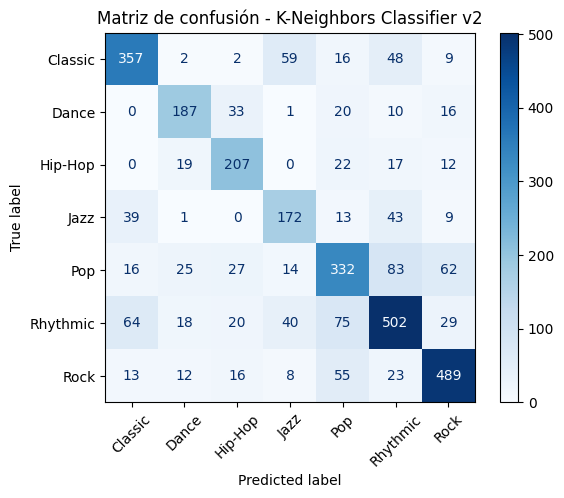

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline_k_neighbors_v2, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - K-Neighbors Classifier v2")
plt.show()

Observamos que se obtuvo una mejora luego del ajute de hiperparámetros.

Sin embargo, según lo investigado, concluímos que al utilizar un K=1 hay un riesgo alto de ***sobreajuste*** ya que el modelo no generaliza casi nada, sino que para cada nueva observación busca el punto más cercano del conjunto de entrenamiento y copia su etiqueta.  

Esto significa que en el conjunto de entrenamiento, el modelo clasifica todo casi perfecto mientras que en el conjunto de test el rendimiento baja.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train_knn2 = pipeline_k_neighbors_v2.predict(X_train)
y_pred_test_knn2 = pipeline_k_neighbors_v2.predict(X_test)

acc_train_knn2 = accuracy_score(y_train, y_pred_train_knn2)
acc_test_knn2 = accuracy_score(y_test, y_pred_test_knn2)

print("Accuracy Train:", acc_train_knn2)
print("Accuracy Test:", acc_test_knn2)


Accuracy Train: 1.0
Accuracy Test: 0.6938523324065493


Como se observa en la comparación anterior, para el conjunto de train se obtiene una precisión perfecta (clasifica todo bien), pero baja notablemente cuando se utiliza el conjunto de test.
Entonces, podríamos concluir que hay sobreajuste. Para ello, aplicaremos validación cruzada.

#### **Validacion cruzada** (teniendo K=1)
Se utilizó la técnica de validación cruzada para evaluar el rendimiento real del modelo. Es por ello que se dividió el conjunto de entrenamiento en 5 subconjuntos (folds) de manera que:
- se entrena con 4 folds y se evalúa con el fold restante
- se repite este proceso 5 veces cambiando el fold de validación
- se calcula el promedio de rendimiento

Esto nos permite estimar cómo generaliza el modelo en diferentes particiones de los datos.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# pipeline con tu preprocesador
pipeline_knn_v3 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=1))
])

# validación cruzada estratificada con 5 particiones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline_knn_v3, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print("Scores en cada fold:", scores)
print("Accuracy promedio:", scores.mean())


Scores en cada fold: [0.66589417 0.65662418 0.66550792 0.64426419 0.66550792]
Accuracy promedio: 0.6595596755504055


Utilizando un `k=1`, se observa que el modelo acierta aproximadamente el 66% de las veces al predecir el género musical durante la validación cruzada.

### ***2. Random Forest Classifier***

***Funcionamiento del modelo***:
este modelo, en lugar de entrenar un sólo árbol, entrena muchos árboles distintos y luego combina sus resultados para obtener una predicción más precisa y estable. Básicamente, el modelo:
1. Crea muchos árboles de decisión.
2. Cada árbol se entrena con una muestra aleatoria de las filas del data set y una selección aleatoria de variables en cada decisión (los árboles aprenden cosas ligeramente diferentes).
3. Cuando se hace una predicción, cada árbol "vota" por una clase y el bosque elige la clase con mayoría de votos.


Dado que observamos una baja precisión en el KNN en la predicción de géneros complejos, decidimos probar con Random Forest.

Este algoritmo, es un ensamble de árboles de decisión. Es por ello que maneja muy bien las interacciones complejas y funciona mejor con respecto a la mezcla de características numéricas y características categóricas.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline con Random Forest
pipeline_rf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# Entrenar
pipeline_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = pipeline_rf.predict(X_test)

evaluar_modelo_prediccion("Random Forest Classifier", y_test, y_pred_rf)


 👀 MODELO: Random Forest Classifier

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.753     0.834     0.791       493
       Dance      0.770     0.779     0.775       267
     Hip-Hop      0.740     0.718     0.729       277
        Jazz      0.854     0.610     0.712       277
         Pop      0.733     0.637     0.681       559
    Rhythmic      0.701     0.773     0.735       748
        Rock      0.844     0.881     0.863       616

    accuracy                          0.761      3237
   macro avg      0.771     0.747     0.755      3237
weighted avg      0.764     0.761     0.759      3237

Matriz de confusión:
[[411   0   0  18   7  43  14]
 [  0 208  25   0   8  16  10]
 [  1  27 199   0  18  22  10]
 [ 52   0   1 169   9  43   3]
 [ 16  19  20   0 356 103  45]
 [ 58   5  16  11  62 578  18]
 [  8  11   8   0  26  20 543]]


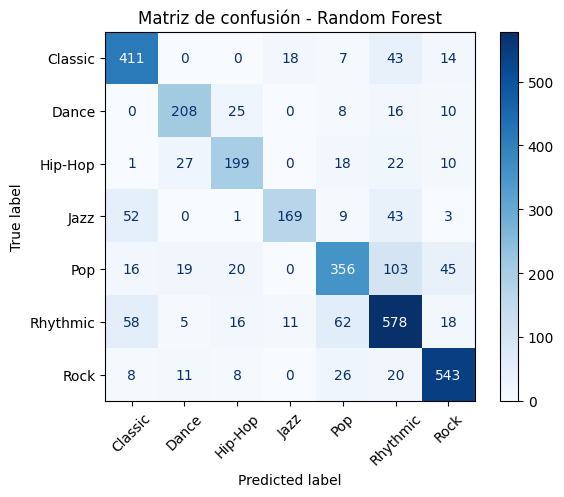

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Random Forest")
plt.show()

Como podemos ver en los resultados obtenidos, se mejoró mucho con respecto al modelo anterior. Sin embargo, consideramos que quizás podría mejorar aún más, por ello también probaremos realizar el ajuste de hiperparámetros.

#### Ajuste de hiperparámetros
Utilizamos GridSearchCV para la búsqueda de hiperparámetros para ver cómo mejorar nuestro modelo.



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {'model__n_estimators': [100, 300, 500],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_

print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor precisión con Cross-Validation: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Mejor precisión con Cross-Validation: 0.7445


Según lo que vemos en los resultados anteriores, será conveniente aplicar los siguientes ajustes a nuestro modelo:
- `max_depth`: None   (límite de profundidad)
- `min_samples_split`: 2   (mínimo de muestras para poder dividir)
- `n_estimators`: 300   (cantidad de árboles)

Entonces, procedemos a realizar dichas modificaciones.

Sin embargo, al no presentar límite de profundidad (se expanden hasta que cada hoja tenga un número mínimo de muestras), se suele aumentar el riesgo de sobreajuste. Es por ello que, luego de obtener los resultados se realizará un análisis.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline con Random Forest
pipeline_rf_v2 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        random_state=42,
        max_depth=None,
        n_estimators=300,
        min_samples_split=2,
        n_jobs=-1))
])

# Entrenar
pipeline_rf_v2.fit(X_train, y_train)

# Predicciones
y_pred_rf_v2 = pipeline_rf_v2.predict(X_test)

evaluar_modelo_prediccion("Random Forest Classifier", y_test, y_pred_rf_v2)


 👀 MODELO: Random Forest Classifier

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.759     0.836     0.795       493
       Dance      0.762     0.768     0.765       267
     Hip-Hop      0.743     0.718     0.730       277
        Jazz      0.870     0.603     0.712       277
         Pop      0.720     0.644     0.680       559
    Rhythmic      0.697     0.770     0.732       748
        Rock      0.847     0.878     0.862       616

    accuracy                          0.760      3237
   macro avg      0.771     0.745     0.754      3237
weighted avg      0.763     0.760     0.758      3237

Matriz de confusión:
[[412   1   0  13   9  47  11]
 [  0 205  25   0  10  15  12]
 [  1  28 199   0  18  22   9]
 [ 53   0   1 167   7  45   4]
 [ 13  19  20   1 360  99  47]
 [ 57   5  16  11  68 576  15]
 [  7  11   7   0  28  22 541]]


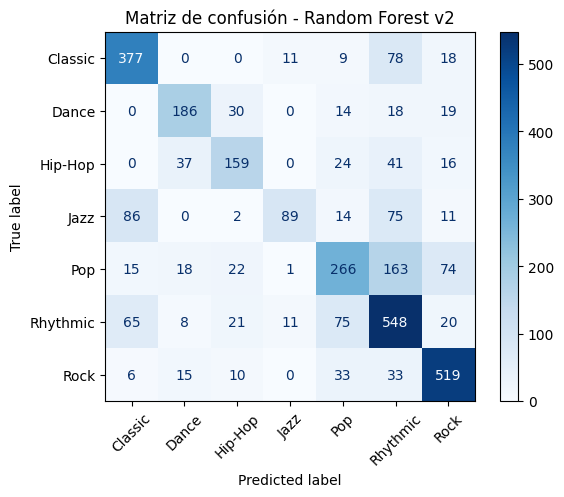

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline_rf_v2, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Random Forest v2")
plt.show()

Notamos que luego de ajustar los parametros, no hubo muchas diferencias con el modelo básico anterior, es decir, los resultados son prácticamente iguales. Por lo que el modelo ajustado no mejora el rendimiento, solo mantiene el mismo nivel de desempeño. Es por ello que, a pesar del riesgo de sobreajuste, creemos que el bosque es lo suficientemente grande y estable como para que el ajuste no afecte su rendimiento.

Según lo investigado, en nuestro caso convendría utilizar el modelo con los hiperparámetros ajustados ya que no se empeora el rendimiento y al tener más árboles, es un poco más estable frente a variaciones. Además que la complejidad extra no pareciera afectar la generalización.

Ahora, para confirmar la estabilidad del modelo, aplicaremos validación cruzada en el modelo ajustado.


#### ***Validación cruzada***
Previo a la aplicación de validación cruzada, veremos el accuracy que se obtiene en el conjunto de entrenamiento y el del conjunto de test.

In [ ]:
y_pred_train_rf2 = pipeline_rf_v2.predict(X_train)
y_pred_test_rf2 = pipeline_rf_v2.predict(X_test)

acc_train_rf2 = accuracy_score(y_train, y_pred_train_rf2)
acc_test_rf2 = accuracy_score(y_test, y_pred_test_rf2)

print("Accuracy Train:", acc_train_rf2)
print("Accuracy Test:", acc_test_rf2)

Accuracy Train: 1.0
Accuracy Test: 0.7599629286376274


Dado que bajo bastante el valor del accuracy en los conjuntos, podríamos creer que hay un leve sobreajuste, es por eso que, aplicaremos a continuación la validación cruzada.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_rf_v2, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores (RF2) en cada fold:", scores)
print("Accuracy (RF2) promedio:", scores.mean())

Scores RF2 en cada fold: [0.64696794 0.64387795 0.64233295 0.64465044 0.64658169]
Accuracy RF2 promedio: 0.6448821938972576


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores (RF base) en cada fold:", scores)
print("Accuracy (RF base) promedio:", scores.mean())

Scores (RF base) en cada fold: [0.74971031 0.74893781 0.74391657 0.74082657 0.74584782]
Accuracy (RF base) promedio: 0.7458478176902279


Al ver estos resultados, podemos concluir que conviene utilizar el Random Forest base (sin el ajuste de hiperparámetros). Esto se debe a que en la validación cruzada obtuvimos un mejor valor de accuracy (74.6%) para dicho modelo, mientras que para el ajustado obtuvimos un valor del 64.5%.

Además, dados los resultados obtenidos, el modelo Random Forest base presenta una mayor capacidad de generalización (es mejor para clasificar canciones que no ha visto antes). También vemos que a pesar de haber obtenido unas métricas similares al principio, el modelo con el ajuste de hiperparámetros resulto ser un peor modelo (la precisión en realidad cayó).

### ***3. Gradient Boosting (XGBoost)***
***Funcionamiento del modelo***: es un algoritmo de ensamble que combina muchas decisiones simples (árboles de decisión débiles). Se basa en aprender de los errores de manera iterativa.
Este modelo, funciona de la siguiente manera:
1. Entrena una serie de árboles de decisión de manera secuencial (no en paralelo como el Random Forest).
2. Cada nuevo árbol que se añade al ensamble se entrena para corregir los errores (residuos) cometidos por el conjunto de árboles anteriores.
3. Utiliza un método de optimización llamado descenso por el gradiente para identificar la dirección en la que debe  ir el siguiente árbol para minimizar la pérdida o el error general.
4. Se introduce un hiperparámetro llamado "tasa de aprendizaje" que controla cuánto debe confiar el modelo en el nuevo árbol.


Luego de investigar, encontramos el "Gradient Boosting" como posible modelo que mejore su rendimiento con respecto al Random Forest. Esto se debe a que XGBoost es conocido por ser "campeon" en la predicción de datos tabulares.

Es por ello que decidimos utilizar ahora este otro modelo .


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

evaluar_modelo_prediccion("Gradient Boosting (XGBoost)", y_test, y_pred_xgb)


 👀 MODELO: Gradient Boosting (XGBoost)

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.771     0.787     0.779       493
       Dance      0.753     0.753     0.753       267
     Hip-Hop      0.764     0.679     0.719       277
        Jazz      0.737     0.606     0.665       277
         Pop      0.672     0.649     0.661       559
    Rhythmic      0.685     0.747     0.715       748
        Rock      0.840     0.869     0.854       616

    accuracy                          0.742      3237
   macro avg      0.746     0.727     0.735      3237
weighted avg      0.742     0.742     0.741      3237

Matriz de confusión:
[[388   0   0  29  15  51  10]
 [  1 201  21   1  17  15  11]
 [  0  28 188   3  20  27  11]
 [ 46   0   0 168  10  47   6]
 [ 10  22  17   6 363  97  44]
 [ 50   8  14  21  76 559  20]
 [  8   8   6   0  39  20 535]]


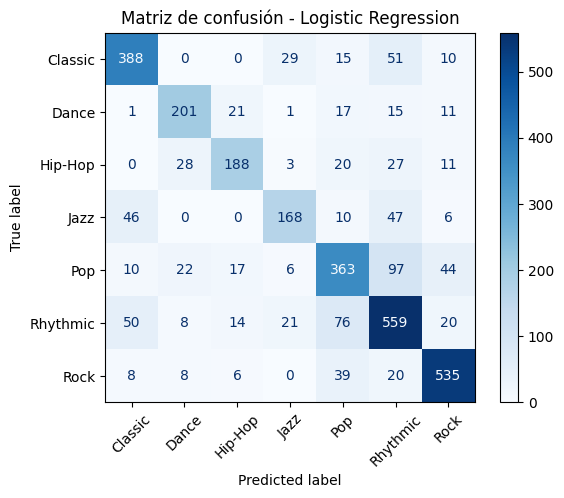

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Gradient Boosting")
plt.show()

De los resultados obtenidos, podemos concluir que obtuvo un accuracy menor que con Random Forest, además se podría decir que el modelo es confiable al predecir el género mostrando un buen balance entre precisión y recall. Sin embargo, al ver el "Macro Avg F1", notamos que al ser inferior que el accuracy, el modelo tiene problemas con las clases minoritarias...

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores (XB base) en cada fold:", scores)
print("Accuracy (XB base) promedio:", scores.mean())

Scores (RF base) en cada fold: [0.72190035 0.72846659 0.7176516  0.7222866  0.72692159]
Accuracy (RF base) promedio: 0.7234453456933179


Observamos que al aplicar validación cruzada, se obtiene una precisión menor que con random forest.

#### Ajuste de hiperparámetros
Utilizamos GridSearchCV para la búsqueda de hiperparámetros para ver cómo mejorar nuestro modelo.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import numpy as np

param_grid_gb = {
    'classifier__n_estimators': [200, 400],
    'classifier__learning_rate': [0.1, 0.05],
    'classifier__max_depth': [3, 4]
}

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

grid_search_gb = GridSearchCV(
    gb_pipeline,
    param_grid_gb,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)

print(f"Mejor combinación de parámetros: {grid_search_gb.best_params_}")
print(f"Mejor Accuracy con validación cruzada: {grid_search_gb.best_score_:.4f}")

Iniciando GridSearch para Gradient Boosting (Busca superar el 76.1% de RF)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejor combinación de parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 400}
Mejor Accuracy con validación cruzada: 0.6800


Ahora, ejecutaremos el mismo modelo con el ajuste de hiperparámetros:
- `learning_rate` = 0.1
- `max_depth` = 4
- `n_estimators` = 400

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_pipeline_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    ))
])

xgb_pipeline_v2.fit(X_train, y_train)

y_pred_xgb_v2 = xgb_pipeline_v2.predict(X_test)

evaluar_modelo_prediccion("Gradient Boosting (XGBoost)", y_test, y_pred_xgb_v2)


 👀 MODELO: Gradient Boosting (XGBoost)

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.744     0.738     0.741       493
       Dance      0.735     0.708     0.721       267
     Hip-Hop      0.735     0.690     0.711       277
        Jazz      0.665     0.538     0.595       277
         Pop      0.643     0.580     0.610       559
    Rhythmic      0.644     0.729     0.684       748
        Rock      0.807     0.860     0.833       616

    accuracy                          0.708      3237
   macro avg      0.710     0.692     0.699      3237
weighted avg      0.707     0.708     0.706      3237

Matriz de confusión:
[[364   0   1  34  15  65  14]
 [  1 189  24   1  19  20  13]
 [  1  30 191   2  18  23  12]
 [ 52   1   1 149  14  53   7]
 [ 12  20  17   7 324 117  62]
 [ 54   7  20  30  73 545  19]
 [  5  10   6   1  41  23 530]]


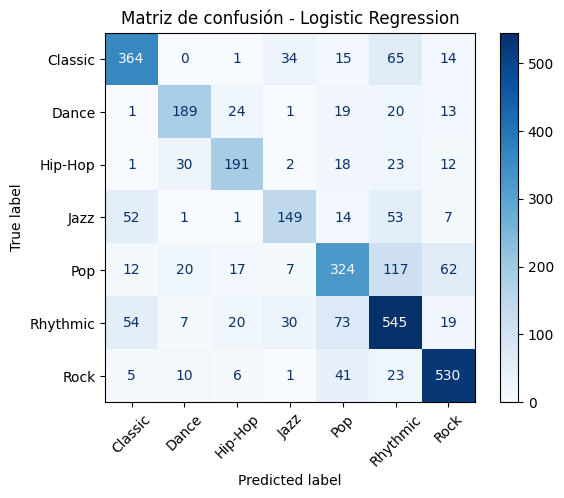

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb_pipeline_v2, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Gradient Boosting")
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_pipeline_v2, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores (XB 2) en cada fold:", scores)
print("Accuracy (XB 2) promedio:", scores.mean())

Scores (RF base) en cada fold: [0.69138664 0.70606412 0.68211665 0.68482039 0.70181537]
Accuracy (RF base) promedio: 0.6932406334492083


Observamos que al hacer el ajuste de hiperparámetros, obtuvimos un rendimiento general peor que con el modelo base. Además, tampoco se logró superar a los resultados obtenidos con Random Forest.

Es por eso que, se realizará un último intento para mejorar el modelo (intentando balancear las clases) únicamente para ***Random Forest***.

### ***Balanceo de clases con SMOTE***


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Random Forest + SMOTE
pipeline_rf_smote = ImbPipeline([
    ("drop_columns", DropColumns(columns_to_drop=["date", "title","track_mbid","genre_dortmund", "genre_tzanetakis","artist_name", "longitud_titulo", "length"])),
    ("music_index_creator", MusicIndexCreator()),
    ("column_transform", column_transform),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

pipeline_rf_smote.fit(X_train, y_train)

y_pred_rf_smote = pipeline_rf_smote.predict(X_test)

evaluar_modelo_prediccion("Random Forest + SMOTE", y_test, y_pred_rf_smote)



 👀 MODELO: Random Forest + SMOTE

Reporte de clasificación:
              precision    recall  f1-score   support

     Classic      0.768     0.826     0.796       493
       Dance      0.703     0.816     0.756       267
     Hip-Hop      0.686     0.758     0.720       277
        Jazz      0.689     0.679     0.684       277
         Pop      0.721     0.639     0.677       559
    Rhythmic      0.749     0.705     0.726       748
        Rock      0.863     0.867     0.865       616

    accuracy                          0.754      3237
   macro avg      0.740     0.756     0.746      3237
weighted avg      0.754     0.754     0.753      3237

Matriz de confusión:
[[407   0   0  36   9  30  11]
 [  0 218  27   0   8   6   8]
 [  0  35 210   0  13  13   6]
 [ 42   0   2 188  10  31   4]
 [ 17  35  25   6 357  79  40]
 [ 55   9  27  39  75 527  16]
 [  9  13  15   4  23  18 534]]


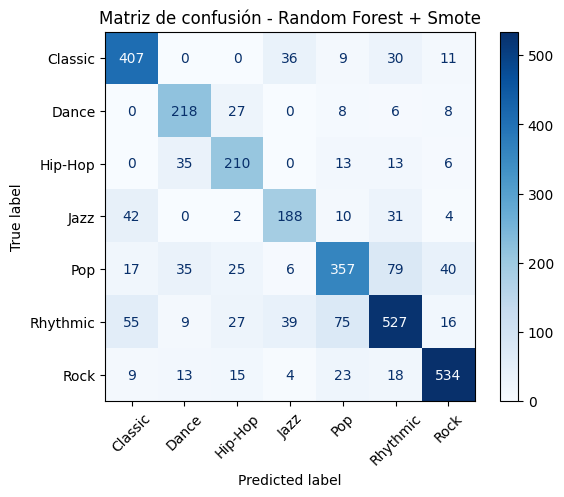

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline_rf_smote, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Random Forest + Smote")
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_rf_smote, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores (RF + smote) en cada fold:", scores)
print("Accuracy (RF + smote) promedio:", scores.mean())

Scores (RF + smote) en cada fold: [0.74198532 0.72421784 0.73735033 0.73812283 0.74623407]
Accuracy (RF + smote) promedio: 0.7375820780224024


Observamos que al balancear las clases se obtiene un rendimiento ligeramente menor que sin el balanceo (accuracy = 73%). Sin embargo, al observar el rendimiento del modelo para cada género, consideramos que se ha obtenido una mejora, ya que a pesar de tener una menor precisión para ciertos géneros, para algunos mejoró.

Entonces, dado que la pérdida del `accuracy` es mínima y el promedio general de `F1` es casi igual, consideramos que el modelo elegido es: ***Random Forest básico***, ya que el objetivo de nuestro sistema de recomendación es lograr una predicción más equitativa entre géneros.
Además, con este modelo observamos una mejora en el recall de las clases minoritarias, lo que significa que el modelo ahora encuentra y clasifica correctamente más canciones de dichas clases minoritarias que antes. Por lo tanto, aunque el modelo sacrifica una fracción de precisión general, se logra una distribución de aciertos más equitativa y justa entre todos los géneros. Y como consideramos que la diversidad es más importante que la máxima precisión sólo para ciertas clases, creemos que este modelo es el que ofrece el mejor equilibrio.





---


## ***Entrenamiento de modelos: Aprendizaje No Supervisado***
A diferencia del Aprendizaje Supervisado, en este tipo de modelos lo que queremos hacer es simplemente *explorar los datos* y *aprender de la naturaleza* de los mismos, sin la idea de llegar a un resultado como en la sección anterior.

En este tipo de aprendizaje, no hay respuestas correctas, solo ***descubrimientos***.

En primer lugar, vamos a colocar la función que vamos a llamar más adelante para seleccionar las features que vamos a utilizar en esta técnica.

In [ ]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona columnas numéricas con baja cantidad de nulos,
    excluyendo aquellas que coincidan con patrones o listas explícitas.
    """
    def __init__(self, umbral_nulos=0.05, excluir_columnas=None, excluir_patrones=None):
        self.umbral_nulos = umbral_nulos
        self.excluir_columnas = excluir_columnas or []
        self.excluir_patrones = excluir_patrones or []

    def fit(self, X, y=None):
        columnas_numericas = X.select_dtypes(include=["number"]).columns
        proporcion_nulos = X[columnas_numericas].isnull().mean()

        columnas_utiles = [
            col for col in columnas_numericas
            if proporcion_nulos[col] <= self.umbral_nulos
        ]

        self.columnas_seleccionadas_ = [
            col for col in columnas_utiles
            if col not in self.excluir_columnas
            and not any(pat in col for pat in self.excluir_patrones)
        ]
        return self

    def transform(self, X):
        return X[self.columnas_seleccionadas_]

Vamos a llamar la función de la celda anterior, eliminando las columnas que queremos excluir del DataFrame.

Se guardará el resultado en `df_filtrado`, y se mostrará la cantidad y el nombre de las columnas que tiene el mismo.

In [ ]:
excluir_columnas = ["date", "longitud_titulo", "decada", "length"] # Se definen las columnas que queremos sacar
excluir_patrones = []

selector = FeatureSelector(
    umbral_nulos=0,
    excluir_columnas=excluir_columnas,
    excluir_patrones=excluir_patrones
)

df_filtrado = selector.fit_transform(df)
print(f"Columnas seleccionadas: {df_filtrado.shape[1]}")
df_filtrado.columns

Columnas seleccionadas: 9


Index(['sad', 'happy', 'party', 'tonal', 'bright', 'relaxed', 'acoustic',
       'danceable', 'instrumental'],
      dtype='object')

### ***1. Reducción de dimensionalidad con PCA***
En esta técnica, lo que se intenta hacer es simplificar los datos existentes del modelo, utilizando lo que se llaman las "componentes principales" y el análisis de las mismas (PCA - Principal Component Analysis).
Estas componentes principales resumen la mayor parte de la información.

#### *PCA Adaptativo*
A través de esta técnica, vamos a ver cuántas componentes se deben mantener para alcanzar un umbral de varianza acumulada. En este caso, vamos a establecer este umbral en 80%.

Para utilizar PCA, vamos a crear la clase de la celda siguiente, en la cual establecemos algunas funciones útiles.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class PCAReducerByVariance(BaseEstimator, TransformerMixin):
    def __init__(self, varianza_objetivo=0.95):
        self.varianza_objetivo = varianza_objetivo

    def fit(self, X, y=None):
        self.feature_names_ = list(X.columns)

        X_proc = SimpleImputer(strategy="median").fit_transform(X)

        X_proc = StandardScaler().fit_transform(X_proc)

        pca_temp = PCA().fit(X_proc)

        self.varianza_acumulada_ = pca_temp.explained_variance_ratio_.cumsum()

        self.n_componentes_ = (self.varianza_acumulada_ >= self.varianza_objetivo).argmax() + 1
        # self.n_componentes_ = 2
        print(f"\n✅ Se necesitan {self.n_componentes_} componentes para explicar al menos el {self.varianza_objetivo:.2%} de la varianza.")

        self.pipeline_ = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=self.n_componentes_))
        ])
        self.pipeline_.fit(X)

        return self

    def transform(self, X):
        return self.pipeline_.transform(X)

    def plot_varianza_acumulada(self):
        if not hasattr(self, "varianza_acumulada_"):
            raise RuntimeError("Debés ajustar el modelo con fit() antes de graficar.")

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(self.varianza_acumulada_)+1), self.varianza_acumulada_, marker="o")
        plt.axhline(self.varianza_objetivo, color="gray", linestyle="--", label=f"{self.varianza_objetivo:.0%} de varianza")
        plt.title("Varianza acumulada por número de componentes")
        plt.xlabel("Número de componentes principales")
        plt.ylabel("Varianza acumulada")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_heatmap_componentes(self):
        if not hasattr(self, "pipeline_"):
            raise RuntimeError("Debés ajustar el modelo con fit() antes de graficar.")

        pca = self.pipeline_.named_steps["pca"]
        componentes = pca.components_
        df_comp = pd.DataFrame(
            data=componentes,
            columns=self.feature_names_,
            index=[f"PC{i+1}" for i in range(componentes.shape[0])]
        ).T

        plt.figure(figsize=(max(10, 0.5 * self.n_componentes_), 0.3 * len(self.feature_names_)))
        sns.heatmap(df_comp, cmap="coolwarm", center=0, annot=True, fmt=".2f", cbar=True)
        plt.title(f"Contribución de cada característica a las primeras {self.n_componentes_} componentes")
        plt.xlabel("Componentes principales")
        plt.ylabel("Características originales")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def get_num_componentes(self):
        return self.n_componentes_

    def get_componentes_dataframe(self):
        pca = self.pipeline_.named_steps["pca"]
        return pd.DataFrame(
            data=pca.components_,
            columns=self.feature_names_,
            index=[f"CP{i+1}" for i in range(pca.n_components_)]
        )


Ya creada la clase en la celda anterior, vamos a llamar a la misma enviando la varianza objetivo (en este caso el 80%), y se va a mostrar por pantalla la cantidad de componentes principales necesarias para explicar al menos la varianza objetivo. En este caso, son 5 las componentes principales necesarias.

Luego, se guarda en la variable `X_reducido` el nuevo conjunto de datos donde cada canción se describe a partir de las componentes principales creadas.

In [ ]:
pca = PCAReducerByVariance(varianza_objetivo=0.80)
X_reducido = pca.fit_transform(df_filtrado)


✅ Se necesitan 5 componentes para explicar al menos el 80.00% de la varianza.


El siguiente gráfico describe la cantidad de componentes principales necesarias para explicar cada porcentaje de la varianza.

Como dato de interés, sabemos que ya con 2 componentes, se explica más de la mitad de la información.

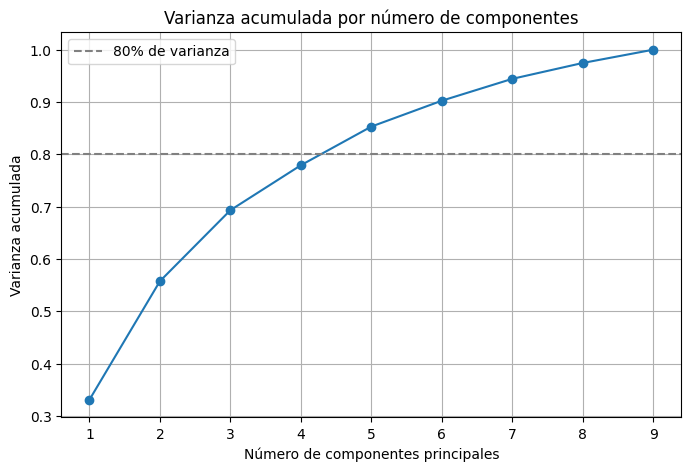

In [ ]:
pca.plot_varianza_acumulada()

En el siguiente gráfico, vamos a ver cuánto aporta cada característica de las canciones a la construcción de las primeras 5 componentes principales.

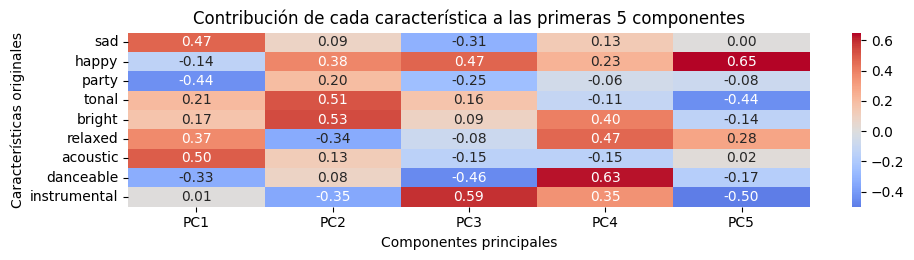

In [ ]:
pca.plot_heatmap_componentes()

Hay variables que dominan cada uno de los componentes (PC1 - PC5):
* **PC1**: está mayormente dominada positivamente por las características `acoustic` y `sad`, y negativamente por `party` y `danceable`. Por el análisis realizado previamente, podría tratarse de canciones de los géneros Jazz y Classic.
* **PC2**: está dominada positivamente por `happy`, `tonal` y `bright`, mientras que sus características más negativas son `instrumental` y `relaxed`. Esto podría significar que se trata de canciones de un género como Pop.
* **PC3**: esta componente está muy fuertemente dominada por la característica `instrumental`. El resto de las características son más bajas, aunque se destacan `danceable`, `tonal` y `bright`. Podría decirse que el género que podría estar representado por estas características es Rock.
* **PC4**: positivamente, está fuertemente dominada por la característica `happy`. Negativamente en cambio, está dominada por `danceable`. En este caso, es difícil poder decir a qué género/s pertenecen las canciones de esta componente, ya que en la entrega anterior no conseguimos este tipo de resultados.
* **PC5**: esta componente tiene influencia positiva de `happy`, `relaxed` y `danceable`. Además, negativamente, está dominada por `tonal`. Por las conclusiones de la entrega anterior, podría decirse que puede tratarse de canciones del género Pop.

#### *PCA Fijo para Visualización*
Esta técnica es ideal para visualizar los datos del dataset. Con esta técnica, podemos detectar si se crean agrupamientos de los datos.

Vamos a comenzar definiendo la clase `PCAPipeline`, que vamos a ir llamando luego.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class PCAPipeline(BaseEstimator, TransformerMixin):
    """
    Pipeline que aplica imputación + escalado + PCA a n componentes.
    """
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=self.n_components))
        ])

    def fit(self, X, y=None):
        self.pipeline.fit(X)
        return self

    def transform(self, X):
        return self.pipeline.transform(X)

    def get_pca_model(self):
        return self.pipeline.named_steps["pca"]

También definiremos esta función `plot_scatter_pca`, que usaremos para graficar la proyección en 2D por PCA.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_scatter_pca(X_pca, etiquetas=None, titulo="Proyección en 2D por PCA"):
    """
    Grafica un scatterplot con los dos primeros componentes principales.

    Parámetros:
    - X_pca: ndarray o DataFrame con al menos 2 columnas (PC1, PC2).
    - etiquetas: opcional, Series o array para colorear los puntos.
    - titulo: título del gráfico.
    """
    if isinstance(X_pca, pd.DataFrame):
        x = X_pca.iloc[:, 0]
        y = X_pca.iloc[:, 1]
    else:
        x = X_pca[:, 0]
        y = X_pca[:, 1]

    plt.figure(figsize=(8, 6))
    if etiquetas is None:
        plt.scatter(x, y, alpha=0.5, s=10)
    else:
        sns.scatterplot(x=x, y=y, hue=etiquetas, palette="Set2", alpha=0.6, s=20)

    plt.title(titulo)
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

En la siguiente celda, vamos a definir qué features se van a seleccionar para el análisis, y se va a graficar la proyección en dos dimensiones.

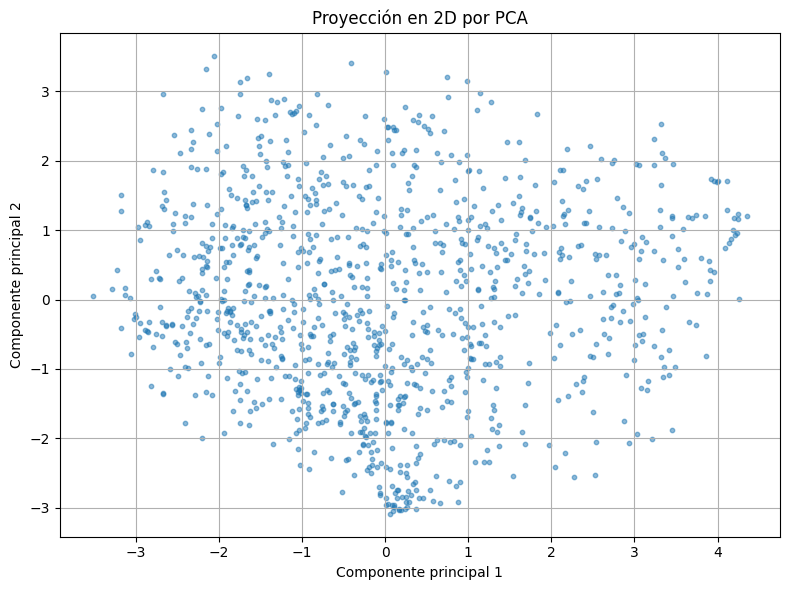

In [ ]:
pipe_pca_2d = Pipeline([
    ("selector", FeatureSelector(
        umbral_nulos=0,
        excluir_patrones=[],
        excluir_columnas=excluir_columnas,
    )),
    ("pca", PCAPipeline(n_components=2))
])

X_reducido_2d = pipe_pca_2d.fit_transform(df_filtrado)
plot_scatter_pca(X_reducido_2d)

En el gráfico anterior podemos ver que no se visualizan o diferencian grupos de datos. En su lugar, los datos representan una sola nube de puntos.

Lo anterior nos sugiere que no hay grandes diferencias o características representativas de cada género, sino que estos suelen mezclarse. Además, sugiere que es necesario utilizar otras técnicas como la clusterización para reconocer grupos de datos similares.

Igualmente, vamos a graficar un heatmap de cómo contribuye cada característica de las canciones a los componentes PC1 y PC2, para ver si podemos sacar alguna conclusión interesante.

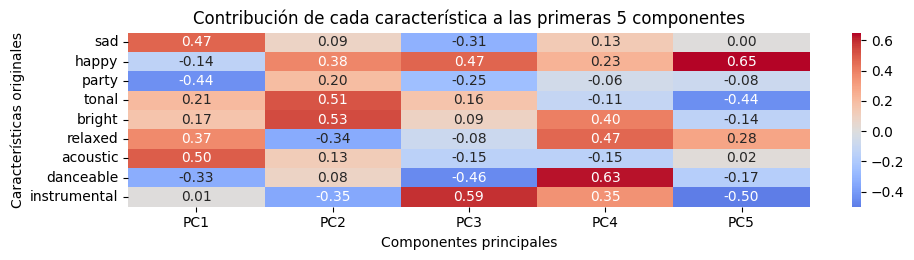

In [ ]:
pca.plot_heatmap_componentes()

A partir del gráfico anterior, se pueden sacar las siguientes conclusiones:
* La **componente principal 1 (PC1)** está influida positivamente por las características `sad`, `relaxed` y `acoustic`, pero negativamente por `party` y `danceable`. Como un punto de partida, aquí tendríamos canciones más bien **tranquilas**.
* La **componente principal 2 (PC2)** está influida positivamente por las características `happy`, `tonal` y `bright`, pero negativamente por `instrumental` y `relaxed`. Como un punto de partida, aquí tendríamos canciones más bien **movidas**.

Para ver si se puede mejorar el análisis, vamos a realizar el mismo gráfico pero esta vez separando por géneros.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class Genero(BaseEstimator, TransformerMixin):
    def __init__(self, columna_original="positions"):
        self.columna_original = columna_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

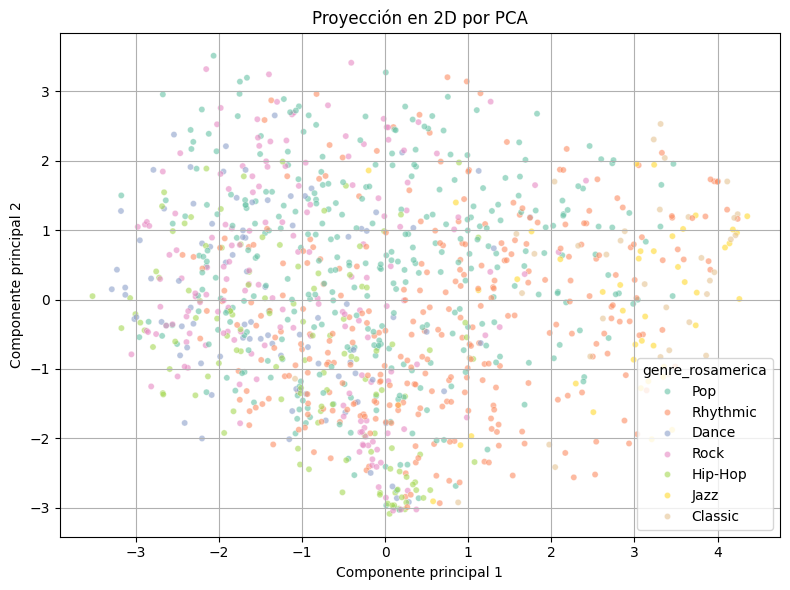

In [ ]:
df = Genero().fit_transform(df)

# Gráfico de dispersión sin etiquetas
plot_scatter_pca(X_reducido_2d, etiquetas=df["genre_rosamerica"])

El gráfico anterior no refuta lo escrito anteriormente: no se forman visualmente grupos de datos de interés que estén bien definidos.

Igualmente, vemos que en el sector izquierdo de la nube se concentran canciones de Rock y Dance, mientras que en la derecha hay bastantes del género Classic y Jazz. Por otro lado, en la parte central se concentra gran cantidad de canciones Rhythmic.

Esto podría tener que ver con lo expuesto anteriormente, donde mostramos cómo aporta cada característica a las dos componentes.




---


#### Exploración en 3D
En esta subsección, vamos a realizar la proyección en tres dimensiones para realizar un análisis más profundo.

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

def plot_3d_pca(X_pca, etiquetas=None, titulo="Proyección PCA (3D)"):
    """
    Grafica la proyección de datos en 3D usando Plotly.

    Parámetros:
    - X_pca: ndarray o DataFrame con al menos 3 columnas (PC1, PC2, PC3)
    - etiquetas: opcional, Series o array para colorear los puntos.
    - titulo: título del gráfico
    """
    if isinstance(X_pca, np.ndarray):
        X_pca = pd.DataFrame(X_pca, columns=["pca_1", "pca_2", "pca_3"])

    df_plot = X_pca.copy()
    if etiquetas is not None:
        df_plot["etiqueta"] = etiquetas
    else:
        df_plot["etiqueta"] = "Punto"

    fig = px.scatter_3d(
        df_plot,
        x="pca_1", y="pca_2", z="pca_3",
        color="etiqueta",
        opacity=0.6,
        title=titulo
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()

En la siguiente celda de código, se llama a la función anterior con la cual se graficará en tres dimensiones.

In [ ]:
pipe_pca_3d = Pipeline([
    ("selector", FeatureSelector(
        umbral_nulos=0,
        excluir_patrones=[],
    )),
    ("pca", PCAPipeline(n_components=3))
    # en vez de pasarle 2, le pasamos 3 para que lo haga en 3d
])

X_reducido_3d = pipe_pca_3d.fit_transform(df_filtrado)
plot_3d_pca(X_reducido_3d)

Ya con el gráfico anterior se puede notar una diferencia al visualizar los datos, ya que se ven más completos. Igualmente, vamos a graficar en diferentes colores para ver si se puede mejorar el análisis.

In [ ]:
df_generos = Genero().fit_transform(df)

plot_3d_pca(X_reducido_3d, etiquetas=df_generos["genre_rosamerica"])

El gráfico en 3D anterior refuerza la teoría que suponíamos más temprano: no existen grupos muy formados ni distinguidos en los datos.

Además del motivo que colocamos anteriormente (que las características entre los géneros suelen mezclarse), otro motivo por el que puede suceder esto es que se evidencia la varianza que no es captada por la visualización.

### ***2. Clustering***
El objetivo de esta técnica es agrupar o encontrar grupos ideales para categorizar nuestros datos, encontrando la mayor división que se ajuste a las propiedas o características de los mismos.

En esta primera celda de código, vamos a definir la clase `KMeansAutoCluster`, que contiene algunas funciones útiles.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
import matplotlib.pyplot as plt

class KMeansAutoCluster(BaseEstimator, TransformerMixin):
    """
    Aplica KMeans eligiendo automáticamente la mejor cantidad de clusters
    según el Silhouette Score. Permite graficar la curva resultante y acceder
    al valor óptimo de k y a las etiquetas generadas.
    """
    def __init__(self, k_range=range(2, 11), random_state=42):
        self.k_range = list(k_range)
        self.random_state = random_state

    def fit(self, X, y=None):
        self.inertias_ = []
        self.silhouettes_ = []
        self.k_models_ = {}

        for k in self.k_range:
            model = KMeans(n_clusters=k, random_state=self.random_state, n_init="auto")
            labels = model.fit_predict(X)
            self.k_models_[k] = model
            self.inertias_.append(model.inertia_)
            # el silohouette mide que tan clusters son los clusters
            self.silhouettes_.append(silhouette_score(X, labels))

        self.k_optimo_ = self.k_range[np.argmax(self.silhouettes_)]
        print(f"el número de clusters óptimo es {self.k_optimo_} con un índice de silueta de {max(self.silhouettes_)} \n")
        self.best_model_ = self.k_models_[self.k_optimo_]
        self.labels_ = self.best_model_.predict(X)
        return self.best_model_.fit(X)

    def predict(self, X):
        return self.best_model_.predict(X)

    def get_labels(self):
        return self.labels_

    def get_optimal_k(self):
        return self.k_optimo_

    def plot_silhouette_curve(self):
        plt.figure(figsize=(6, 4))
        plt.plot(self.k_range, self.silhouettes_, marker="o", color="green")
        plt.axvline(self.k_optimo_, color="gray", linestyle="--", label=f"k óptimo = {self.k_optimo_}")
        plt.title("Silhouette Score vs cantidad de clusters")
        plt.xlabel("Número de clusters")
        plt.ylabel("Silhouette Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Con la siguiente celda de código, vamos a hacer uso de la clase definida en la celda anterior, para imprimir la cantidad de clusters óptimo junto con el índice de silueta o "silhouette score" en dos, tres y cinco dimensiones.

In [ ]:
# Clustering automático
selector = FeatureSelector(
    umbral_nulos=0,
    excluir_patrones=[],
)

# son como 30 corridas
pca2d = PCAPipeline(n_components=2)
pca3d = PCAPipeline(n_components=3)
pca5d = PCAPipeline(n_components=5)


pipe_autocluster_2d = Pipeline([
    ("selector", selector),
    ("pca", pca2d),
    ("cluster", KMeansAutoCluster())
])

pipe_autocluster_3d = Pipeline([
    ("selector", selector),
    ("pca", pca3d),
    ("cluster", KMeansAutoCluster())
])

pipe_autocluster_5d = Pipeline([
    ("selector", selector),
    ("pca", pca5d),
    ("cluster", KMeansAutoCluster())
])

pipe_autocluster_2d.fit(df_filtrado)
pipe_autocluster_3d.fit(df_filtrado)
pipe_autocluster_5d.fit(df_filtrado)

el número de clusters óptimo es 3 con un índice de silueta de 0.4057385709282266 

el número de clusters óptimo es 4 con un índice de silueta de 0.3327241273582881 

el número de clusters óptimo es 2 con un índice de silueta de 0.25479548574380473 



Pipeline(steps=[('selector',
                 FeatureSelector(excluir_columnas=[], excluir_patrones=[],
                                 umbral_nulos=0)),
                ('pca', PCAPipeline(n_components=5)),
                ('cluster',
                 KMeansAutoCluster(k_range=[2, 3, 4, 5, 6, 7, 8, 9, 10]))])

Como se puede ver en el output anterior, se obtuvo que la cantidad óptima de clusters es 2, con silhouette scores entre 0.30 y 0.40 aproximadamente.

Para mayor claridad, graficaremos el silhouette score en cada dimensión, cuando la cantidad de clusters va subiendo.

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_silhouettes(modelos, nombres=None, figsize=(5, 4)):
    """
    Dibuja los gráficos de Silhouette Score de múltiples modelos KMeansAutoCluster en una sola fila.

    Parámetros:
    - modelos: lista de objetos KMeansAutoCluster ya entrenados
    - nombres: lista de títulos opcionales para cada subplot
    - figsize: tamaño base de cada gráfico individual (ancho, alto)
    """
    n = len(modelos)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]), sharey=True)

    if n == 1:
        axes = [axes]

    for i, (modelo, ax) in enumerate(zip(modelos, axes)):
        k_range = modelo.k_range
        sils = modelo.silhouettes_
        k_opt = modelo.get_optimal_k()

        ax.plot(k_range, sils, marker="o", color="green")
        ax.axvline(k_opt, color="gray", linestyle="--", label=f"k óptimo = {k_opt}")
        ax.set_xlabel("Clusters (k)")
        if i == 0:
            ax.set_ylabel("Silhouette Score")
        if nombres:
            ax.set_title(nombres[i])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


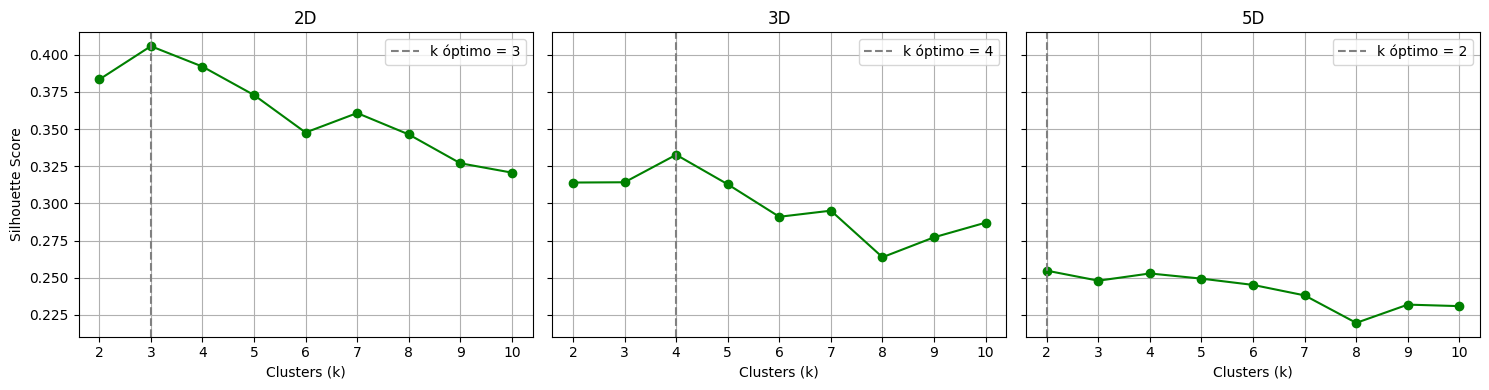

In [ ]:
plot_multiple_silhouettes(
    [pipe_autocluster_2d["cluster"], pipe_autocluster_3d["cluster"], pipe_autocluster_5d["cluster"]],
    nombres=["2D", "3D", "5D"]
)

En estos gráficos, vemos que efectivamente el mejor k se alcanza en 2.

Aún así, vemos que la diferencia con tener cualquier cantidad de clusters más, no es significativa. Esto indica que los nuevos clusters no estarían tan bien definidos.

### ***3. PCA + Clustering***
En esta sección, vamos a reutilizar todo lo que realizamos anteriormente, en un solo pipeline completo.

Comenzamos definiendo la clase que se va a utilizar en Pipeline, más adelante.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pandas as pd

class ClusterPCA_Completo(BaseEstimator, TransformerMixin):
    def __init__(self, selector, pca, cluster):
        self.pipeline = Pipeline([
            ("selector", selector),
            ("pca", pca),
            ("cluster", cluster)
        ])

    def fit(self, X, y=None):
        self.pipeline.fit(X)
        return self

    def transform(self, X):
        X_pca = self.pipeline[:2].transform(X.copy())

        n_components = X_pca.shape[1]
        nombres_columnas = [f"pca_{i+1}" for i in range(n_components)]
        coords = pd.DataFrame(X_pca, columns=nombres_columnas, index=X.index)

        etiquetas = self.pipeline.named_steps["cluster"].predict(X_pca)

        X_out = X.join(coords)
        X_out["cluster"] = etiquetas
        return X_out

En esta celda, vamos a consturir el Pipeline y llamar a la función anterior.

Los cambios se aplicarán al DataFrame original, guardando el resultado en `df_clusterizado`.

In [ ]:
from sklearn.cluster import KMeans

selector = FeatureSelector(
    excluir_patrones=[]
)
pca = PCAPipeline(n_components=5)
cluster = KMeans(n_clusters=2, random_state=42, n_init="auto")

pipeline = ClusterPCA_Completo(selector, pca, cluster)

df_clusterizado = pipeline.fit_transform(df)

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning:

This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.



Ahora vamos a realizar una tabla que agrupe a los géneros según el cluster al que pertenecen.

In [ ]:
df_clusterizado.groupby("genre_rosamerica").agg({
    "cluster": "value_counts"})

cluster
genre_rosamerica cluster         
Classic          1             35
                 0              1
Dance            0             80
                 1             12
Hip-Hop          0             85
                 1             36
Jazz             1             43
                 0              1
Pop              0            199
                 1            130
Rhythmic         1            184
                 0            124
Rock             0            110
                 1             57

Como se puede ver en la tabla anterior, las canciones de cada uno de los géneros no encajan en un solo cluster, *sino que en dos*.
Igualmente, se puede ver cierta tendencia de cada uno de los clusters, ya que cada género presenta una mayor cantidad en alguno de los dos.
Con ello, podemos decir que:
* El cluster 0 representa canciones más bien **movidas**, al tener en su propiedad grandísima cantidad de canciones de los géneros Dance, Hip-Hop, Pop y Rock.
* El cluster 1 en cambio, tiene canciones más bien **tranquilas**, al poseer en su mayoría canciones de los géneros Classic, Jazz y Rhythmic.

Con esto, podemos llegar a la conclusión de que, aunque no se formó la cantidad esperada de clusters (nosotras pensábamos que se iba a formar un cluster por género), el resultado no fue tan alejado de la realidad: en general, existen canciones más movidas o más tranquilas, no hay una característica fuertemente definida por cada género.

Para mayor claridad, vamos a hacer un gráfico de radar que nos permita ver la diferencia de características entre las canciones del Cluster 0 y del Cluster 1.

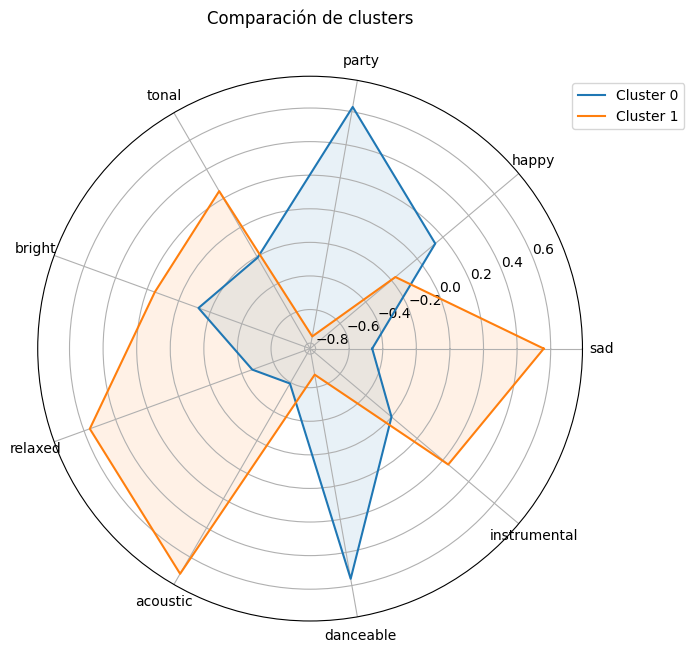

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pipeline_radar = Pipeline([
        ("selector",FeatureSelector(
                excluir_patrones=["pca_"],
                excluir_columnas=excluir_columnas),
            ),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
])

X_sel = pipeline_radar.fit_transform(df_clusterizado)

columnas = pipeline_radar.named_steps["selector"].columnas_seleccionadas_

X_sel_df = pd.DataFrame(X_sel, columns=columnas, index=df_clusterizado.index)

etiquetas = df_clusterizado["cluster"]

def plot_radar_clusters(X, labels, titulo="Radar por cluster"):
    df_mean = X.copy()
    df_mean["cluster"] = labels
    medias = df_mean.groupby("cluster").mean()

    categorias = medias.columns.tolist()
    N = len(categorias)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for i, row in medias.iterrows():
        valores = row.tolist()
        valores += valores[:1]
        ax.plot(angles, valores, label=f"Cluster {i}")
        ax.fill(angles, valores, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias, fontsize=10)
    ax.set_title(titulo, y=1.08)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

plot_radar_clusters(X_sel_df, etiquetas, titulo="Comparación de clusters")

Con este gráfico de radar, podemos confirmar lo que habíamos dicho antes:
* El Cluster 0 tiene altas características de `party`, `danceable` `happy` y `bright`.
* El Cluster 1 tiene proporciones altas en las características `acoustic`, `relaxed` y `sad`. Aunque también tiene alta `bright`.

De esta manera, podemos decir que el Cluster 0 concentra canciones más bien "tranquilas", mientras que el Cluster 1 concentra las más "movidas".

### ***4. Detección de Anomalías***
Con esta técnica, queremos detectar cuáles son los datos anómalos, es decir, aquellas canciones que no encajan en los Clusters 0 y 1 definidos anteriormente.

Para encontrar estas anomalías, utilizaremos el algoritmo "Isolation Forest".

Lo que hace este algoritmo es realizar "preguntas" a cada canción, e identificar aquellas cuyas características sean contradictorias. Un ejemplo de esto podría ser una canción con alto porcentaje de `danceable`, pero también de `sad`.

Lo que hace el código es definir las características o features a utilizar (en nuestro caso serían `happy`, `sad`, etc.) y entrenar el modelo. Así, devuelve:
* **1 si se trata de un punto "normal"**
* **-1 si se trata de un punto "anómalo"**

Este resultado lo va a añadir al DataFrame `df_anomalo`, e imprimirá por pantalla la cantidad de anomalías encontradas.

In [ ]:
from sklearn.ensemble import IsolationForest

df_anomalo = df_clusterizado

features = ['sad', 'happy', 'party', 'relaxed', 'acoustic', 'danceable', 'tonal', 'bright', 'instrumental']
X = df_anomalo[features]

iso_forest = IsolationForest(contamination=0.02, random_state=42)

predictions = iso_forest.fit_predict(X)

df_anomalo['anomaly'] = predictions

print("Número de anomalías encontradas:", df_anomalo[df_anomalo['anomaly'] == -1].shape[0])

Número de anomalías encontradas: 22


Como se puede ver, el resultado arrojó que se encontraron **323 anomalías**. Esto representa un 0.02% de la cantidad total de canciones.

Para visualizar las anomalías en un gráfico, vamos a reutilizar lo que hicimos anteriormente de la proyección en 2D, y vamos a resaltar en color rojo aquellos datos que son anómalos. En color gris, se dejan aquellos datos normales.

In [ ]:
X_pca_2d = pipe_autocluster_2d.named_steps['pca'].transform(df_anomalo[features])

plt.figure(figsize=(12, 8))
plt.scatter(X_pca_2d[df_anomalo['anomaly'] == 1, 0], X_pca_2d[df_anomalo['anomaly'] == 1, 1], c='lightgray', label='Normal')
plt.scatter(X_pca_2d[df_anomalo['anomaly'] == -1, 0], X_pca_2d[df_anomalo['anomaly'] == -1, 1], c='red', edgecolor='k', s=80, label='Anomalía')

plt.title('Visualización de Anomalías sobre PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


En el gráfico anterior, se puede notar visualmente que los datos anómalos no representan siquiera un 1% de la cantidad total.

Para analizar algunos ejemplos de canciones anómalas, imprimiremos una tabla con las mismas, con todas sus características.

In [ ]:
anomalous_songs = df[df['anomaly'] == -1]

print(f"Estas son las {anomalous_songs.shape[0]} canciones anómalas del dataset:")
display(anomalous_songs[features + ['genre_rosamerica']])

KeyError: 'anomaly'

A simple vista, resalta:
* La canción de la fila 5, que tiene un alto porcentaje de `party`, pero al mismo tiempo uno alto de `relaxed` y uno bajo de `danceable`.
* La canción de la fila 16206, con un alto porcentaje de `happy`, pero también de `sad`.

Con esto, queremos llegar a la conclusión de que estos datos son anómalos al ser contradictorios en sus propias características. También pueden tratarse de canciones de géneros diferentes a las de la columna `genre_rosamerica`, siendo el modelo capaz de detectar estas excepciones.



---

Como conclusión final de la sección de Aprendizaje No Supervisado, podemos decir que hemos conseguido hallazgos interesantes: se logró separar las canciones entre **movidas** y **tranquilas**, y no necesariamente por géneros.

A partir de esta conclusión, pensamos que sería posible encarar el proyecto de recomendación de canciones según el estado de ánimo o evento que tenga el usuario. Por ejemplo, si desea armar una lista de canciones para una fiesta, se le podría recomendar canciones del conjunto más **movido**, mientras que si desea armar la lista para una juntada con amigos, se le podría recomendar canciones del conjunto más **tranquilo**.

In [ ]:
df_anomalo.columns

Index(['sad', 'date', 'happy', 'party', 'title', 'tonal', 'bright', 'length',
       'relaxed', 'acoustic', 'danceable', 'track_mbid', 'artist_name',
       'instrumental', 'genre_dortmund', 'genre_rosamerica',
       'genre_tzanetakis', 'decada', 'longitud_titulo', 'pca_1', 'pca_2',
       'pca_3', 'pca_4', 'pca_5', 'cluster', 'anomaly'],
      dtype='object')

In [ ]:
# Exportación de DataFrame final
columnas_deseadas = [
    'title', 'artist_name', 'track_mbid', 'date', 'length',
    'genre_dortmund', 'genre_rosamerica', 'genre_tzanetakis',
    'sad', 'happy', 'party', 'relaxed', 'acoustic', 'danceable',
    'tonal', 'bright', 'instrumental', 'decada', 'longitud_titulo',
    'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'cluster', 'anomaly'
]

df_anomalo.to_csv(
    'songs_final_1000_canciones.csv',
    index=False,
    columns=columnas_deseadas
)
from google.colab import files
files.download('songs_final_1000_canciones.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>